**Question 7 [Discriminative vs Generative Models, 25 Marks]**<br>

I. Load Task1E_train.csv and Task1E_test.csv as well as the Bayesian classifier (BC) and logistic regression (LR) codes from Activities 2 and 3 in Module 3.

#### Importing the data

In [1]:
train <- read.csv('data\\Sintentic1E_train.csv')
test <- read.csv('data\\Sintentic1E_test.csv')
train.data <- train[, 1:2]
test.data <- test[, 1:2]
train.label <- train[, 3]
test.label <- test[, 3]

In [2]:
head(train.data)

,x1,x2
,<dbl>,<dbl>
1,-0.4367052,3.171451
2,5.1048972,1.227815
3,3.9974518,1.049502
4,2.5354540,1.242902
5,4.2624556,2.551909
6,1.5505866,2.595164


#### Importing Libraries

In [3]:
# Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

## Bayesian Classifier 

These are the steps to build a bayesian Classifier:
<ol>
	<li>Calculate the class priors $p(\mathcal{C}_k)$ based on the relative number of training data in each class,</li>
	<li>Calculate the class means $\mu_k$, class covariance matrices $\mathbf{S}_k$ and shared covariance matrix $\Sigma$ using the training data,</li>
	<li>Using the estimated PDF function, calculate $p(x_n|\mathcal{C}_k)$ for each data point and each class,</li>
	<li>For each test sample, find the class label $\mathcal{C}_k$ that maximizes the $p(\mathcal{C}_k)p(x_n|\mathcal{C}_k)$,</li>
</ol>

In the following we take these steps one by one.

In [4]:
bayesclass <- function(train.data, train.label, test.data, test.label) {

    labels <- sort(unique(train.label), decreasing = TRUE)
    
    # Class probabilities:
    p0.hat <- sum(train.label == labels[1])/nrow(train.data) # total number of samples in class 0 divided by the total nmber of training data
    p1.hat <- sum(train.label == labels[2])/nrow(train.data) # or simply 1 - p1.hat

    # Class means:
    mu0.hat <- colMeans(train.data[train.label == labels[1], ])
    mu1.hat <- colMeans(train.data[train.label == labels[2], ])

    # class covariance matrices:
    sigma0.hat <- var(train.data[train.label == labels[1], ])
    sigma1.hat <- var(train.data[train.label == labels[2], ])

    # shared covariance matrix:
    sigma.hat <- p0.hat * sigma0.hat + p1.hat * sigma1.hat 

    # calculate posteriors:
    posterior0 <- p0.hat*dmvnorm(x=train.data, mean=mu0.hat, sigma=sigma.hat)
    posterior1 <- p1.hat*dmvnorm(x=train.data, mean=mu1.hat, sigma=sigma.hat)
    
    # calculate predictions:
    train.predict <- ifelse(posterior0 > posterior1, labels[1], labels[2])
    test.predict <- ifelse(p0.hat*dmvnorm(x=test.data, mean=mu0.hat, sigma=sigma.hat) > 
                           p1.hat*dmvnorm(x=test.data, mean=mu1.hat, sigma=sigma.hat), labels[1], labels[2])

    # calculate misclassification:
    error.train <- 1-sum(train.label==train.predict)/nrow(train.data)
    error.test <- 1-sum(test.label==test.predict)/nrow(test.data)

    return(c(error.train, error.test))
    
}

## Logistic Regression

Steps to Build a Logistic Regression <br> 

Taking the following steps is neccesseary to build a logistic regression:
<ol>
	<li>Implement sigmoid function $\sigma(\pmb{w}.\mathbf{x})$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and stopping criterion $\epsilon$.</li>
	<li>Repeat the followings until the improvement becomes negligible (i.e., $|\mathcal{L}(\pmb{w}^{(\tau+1)})-\mathcal{L}(\pmb{w}^{(\tau)})| \lt \epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} - \eta (\sigma(\pmb{w}.\mathbf{x}) - t_n) \pmb{x}_n$</li>
</ol>
</li>
</ol>
</li>
</ol>

In the followings, we implement each of these steps.

### Auxilary Functions

In [5]:
# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, -log(1-sig), -log(sig))/nrow(X)))
}

# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

**Step 1 (initializations):** Now, we initiate the weight vector, learning rate, stopping threshold, etc.

In [6]:
logistic <- function(train.data, train.label, test.data, test.label, tau.max = 1000, eta = 0.01, epsilon = 0.01) {

    labels <- sort(unique(train.label))
    c0 <- labels[2]
    c1 <- labels[1]
    tau <- 1 # iteration counter
    terminate <- FALSE
    train.len <- nrow(train.data) 

    ## Just a few name/type conversion to make the rest of the code easy to follow
    X_train <- as.matrix(train.data) # rename just for conviniance
    X_test <- as.matrix(test.data) # rename just for conviniance    
    T_train <- ifelse(train.label == c0, 0, 1) # rename just for conviniance
    T_test <- ifelse(test.label == c0, 0, 1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X_train)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight (any better idea?)

    # project data using the sigmoid function (just for convenient)
    Y <- sigmoid(W[1,],X_train)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration
    costs[1, 'cost_train'] <- cost(W[1,],X_train, T_train, 0)

    
    while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X_train,T_train, 0) <=epsilon

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)

        X_train <- X_train[train.index,]
        T_train <- T_train[train.index]

        # for each datapoint:
        for (i in 1:train.len){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X_train,T_train, 0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X_train)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T_train[i]) * cbind(1, t(X_train[i,]))

            # record the cost:
            costs[(tau+1), 'cost_train'] <- cost(W[tau,],X_train, T_train , 0)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
            eta = eta * 0.999
        }
    }
    # Done!
    costs <- costs[1:tau, ] # remove the NaN tail of the vector (in case of early stopping)
    # the  final result is:
    w <- W[tau,]
    # calculate misclassification:
    train.predict <-predict(w, train.data, c0, c1) 
    test.predict <- predict(w, X_test, c0, c1) 
    error.train <- 1-sum(train.label==train.predict)/nrow(train.data)
    error.test <- 1-sum(test.label==test.predict)/nrow(test.data)

    return(c(error.train, error.test))
    
}

In [7]:
set.seed(1)
logistic(train.data, train.label, test.data, test.label)

[1] 0.026 0.016


II. Using the first 5 data points from the training set, train a BC and a LR model, and compute their training and testing errors. In a “for loop”, increase the size of training set (5 data points at a time), retrain the models and calculate their training and testing errors until all training data points are used. In one figure, plot the training errors of the BC and LR models (with different colors) versus the size of the training set and in the other figure, plot the testing errors of the BC and LR models(with different colors) versus the size of the training set; include two plots in your Jupyter Notebook file for Question 7.


In [8]:
sequence <- seq(from = 5, to = nrow(train.data), by = 5)
logistic_error_train <- c()
logistic_error_test <- c()
bayes_error_train <- c()
bayes_error_test <- c()
j=1 # initialize counter for vectors errors
set.seed(1234)
for (i in sequence){
    
    logistic_error <- logistic(train.data[1:i,], train.label[1:i], test.data, test.label)
    logistic_error_train[j] <- logistic_error[1]
    logistic_error_test[j] <- logistic_error[2]

    bayes_error <- bayesclass(train.data[1:i,], train.label[1:i], test.data, test.label)
    bayes_error_train[j] <- bayes_error[1]
    bayes_error_test[j] <- bayes_error[2]
    
    j=j+1
}   


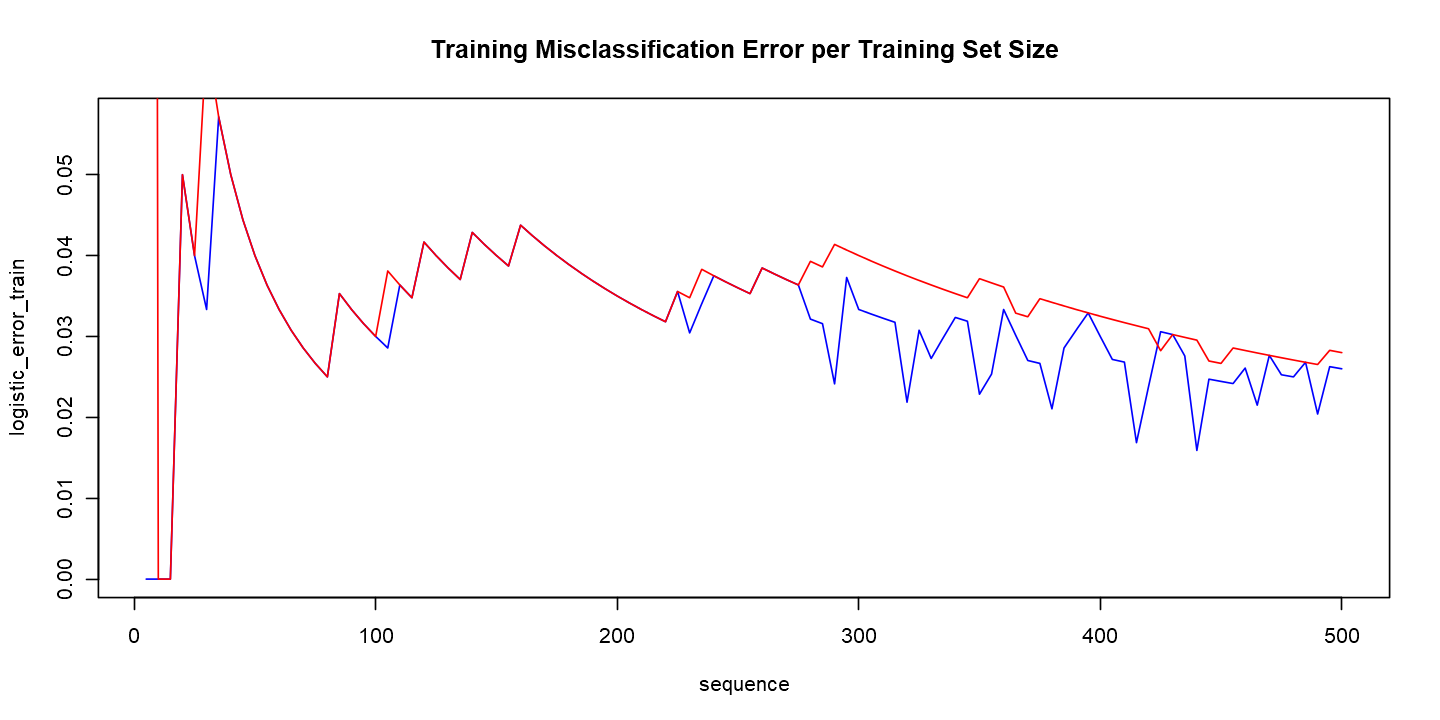

In [9]:
options(repr.plot.width=12, repr.plot.height=6) # area of display

plot(x = sequence, y = logistic_error_train, col = "blue", 
     main = "Training Misclassification Error per Training Set Size", type = "l")
lines(x = sequence, y = bayes_error_train, col = "red")


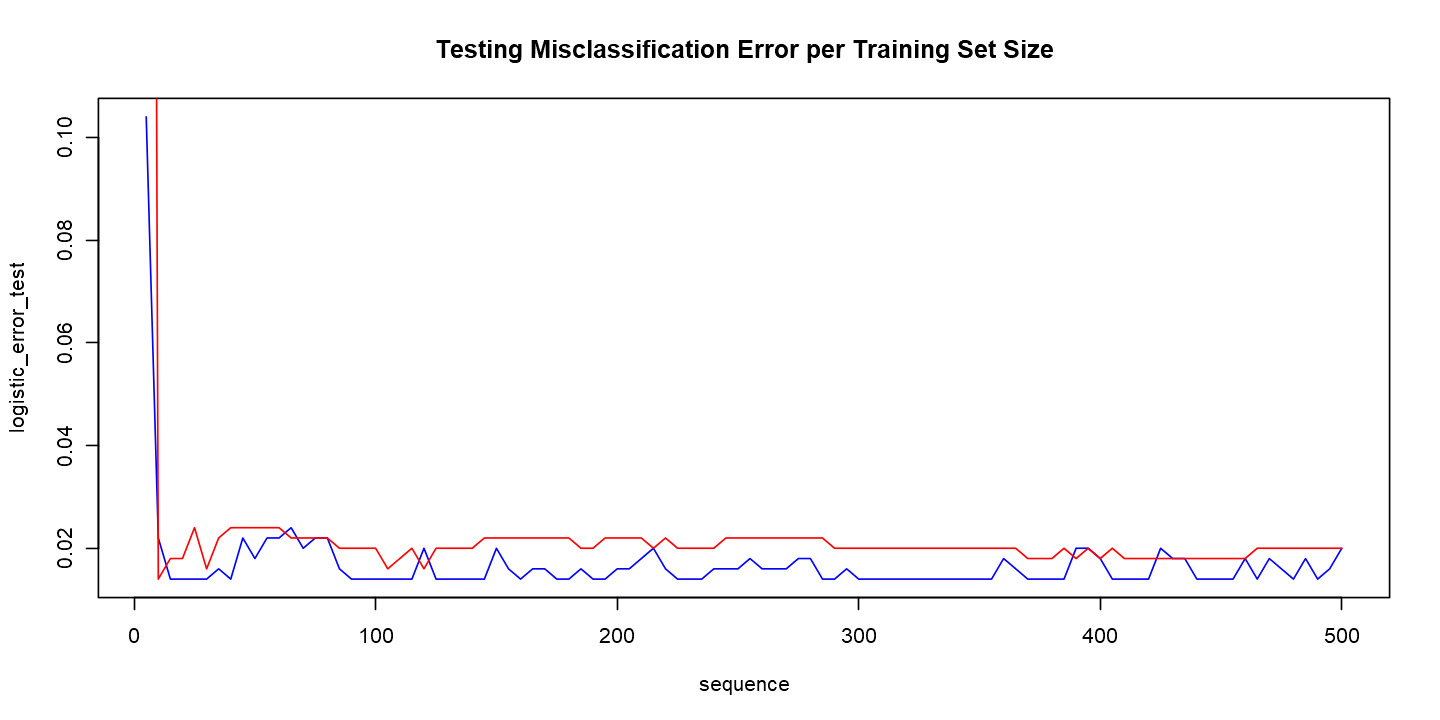

In [10]:
options(repr.plot.width=12, repr.plot.height=6) # area of display

plot(x = sequence, y= logistic_error_test, col = "blue", 
     main = "Testing Misclassification Error per Training Set Size", type = "l")
lines(sequence, bayes_error_test, col = "red")


    III. Explain your observations in your Jupyter Notebook file:
    
        a. What does happen for each classifier when the number of training data points is increased?

Both classifiers have similar behaviour. There is a clear trend for the decrease of the missclassication as the number of trainning data increases.  

        b. Which classifier is best suited when the training set is small, and which is best suited when the training set is big?


The classifiers have similar performance. Anyway, we can see the logistic regression performing better 


    c. Justify your observations in previous questions (III.a & III.b) by providing some speculations and possible reasons. Hint: Think about model complexity and the fundamental concepts of machine learning covered in Module 1.
    
    
    

Your answer is reasonable. But here are some comments: It is difficult to evaluate which model does better in extreme low data scenarios (like 5 points) but generally speaking, when data is relatively low, usually Bayesian classifier performs better despite having many more parameters. The reason is that it is a generative model and hence it tries to model the underlying generation process rather than the discriminative boundary directly. This makes it more robust to operate when data is relatively small in size. Your answer is reasonable though given the observations obtained from the plots.
